<a href="https://colab.research.google.com/github/mrpep/my-colabs/blob/master/Cositas_de_DSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa --upgrade
exit()

In [ ]:
import librosa
from IPython.display import Audio
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de espectrogramas en GPU vs CPU

In [ ]:
!nvidia-smi

In [ ]:
#@title Performance en GPU vs CPU
# Funcion generica para cálculo de espectrogramas, melspectrogramas tanto en CPU como GPU
def spectrogram(x, hardware = 'gpu', stft_params = None, mel_params = None, representation = 'magnitude', eps=1e-12, sr=16000, n_mfcc=12):
  """
  hardware: puede ser 'gpu' o 'cpu'
  stft_params: diccionario con las siguientes claves:
  - window_size
  - window
  - hop_size
  - fft_size: por default es igual a window_size
  mel_params: diccionario con las siguientes claves:
  - lower_edge_hertz: frecuencia minima en Hz usada en el calculo de melspectrogramas
  - upper_edge_hertz: frecuencia maxima en Hz usada en el calculo de melspectrogramas
  - num_mel_bins: cantidad de filtros en escala Mel utilizados
  representation: atributos espectrales a calcular. Puede ser:
  - stft: transformada de corto término de Fourier (STFT)
  - magnitude: magnitud de la STFT
  - phase: fase de la STFT
  - melspectrogram: espectrograma en escala de frecuencias mel
  - logmelspectrogram
  - mfcc: coeficientes cepstrales en frecuencia mel
  eps: pequeño valor sumado al calcular logs para evitar posibles log(0)
  sr: sampling rate, utilizado al calcular melspectrogramas, logmelspectrogramas y mfccs
  n_mfcc: cantidad de MFCCs
  """
  if hardware == 'gpu':
    x = tf.signal.stft(x,
                       frame_length=stft_params['window_size'],
                       frame_step=stft_params['hop_size'],
                       fft_length=stft_params.get('fft_size',stft_params['window_size']),
                       window_fn=stft_params.get('window',tf.signal.hann_window))
    if representation == 'magnitude':
      return tf.abs(x)
    elif representation == 'stft':
      return x
    elif representation == 'phase':
      return tf.angle(x)
    elif representation in ['melspectrogram','logmelspectrogram','mfcc']:
      x = tf.abs(x)
      linear_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(sample_rate=sr,**mel_params)
      melspectrogram = tf.matmul(x,linear_to_mel_matrix)
      logmelspectrogram = tf.math.log(melspectrogram + eps)
      if representation == 'melspectrogram':
        return melspectrogram
      elif representation == 'logmelspectrogram':
        return logmelspectrogram
      elif representation == 'mfcc':
        return tf.signal.mfccs_from_log_mel_spectrograms(logmelspectrogram)[:n_mfcc]
  elif hardware == 'cpu':
    def cpu_spectral_features(x):
      if representation in ['stft','magnitude','phase']:
        y = librosa.stft(x, 
                         n_fft=stft_params.get('fft_size',stft_params['window_size']),
                         hop_length=stft_params['hop_size'],
                         win_length=stft_params['window_size'],
                         window=stft_params.get('window',np.hanning))
        if representation == 'stft':
          return y
        elif representation == 'magnitude':
          return np.abs(y)
        elif representation == 'phase':
          return np.angle(y)
      elif representation in ['melspectrogram','logmelspectrogram']:
        y = librosa.melspectrogram(x,
                                   sr=sr,
                                   n_fft=stft_params.get('fft_size',stft_params['window_size']),
                                   hop_length=stft_params['hop_size'],
                                   win_length=stft_params['window_size'],
                                   fmin=mel_params['lower_edge_hertz'],
                                   fmax=mel_params['upper_edge_hertz'],
                                   n_mels=mel_params['num_mel_bins'])
        if representation == 'melspectrogram':
          return y
        elif representation == 'logmelspectrogram':
          return np.log(y + eps)
      elif representation == 'mfcc':
        return librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=n_mfcc,
                                    n_fft=stft_params.get('fft_size',stft_params['window_size']),
                                    hop_length=stft_params['hop_size'],
                                    win_length=stft_params['window_size'],
                                    fmin=mel_params['lower_edge_hertz'],
                                    fmax=mel_params['upper_edge_hertz'],
                                    n_mels=mel_params['num_mel_bins'])

    spec = list(map(cpu_spectral_features,x))
    return np.stack(spec)

stft_params = dict(window_size=2048, hop_size=512)

times = []
device = []
win_lengths = []

reps = 10
N = 100

possible_win_lengths = 2**(np.arange(5,14))
test_signal = np.random.uniform(-1,1,size=(N,16384))
for win_length in tqdm.tqdm(possible_win_lengths):
  stft_params['window_size'] = int(win_length)
  stft_params['hop_size'] = int(win_length/2)
  for rep in range(reps):
    start = timer()
    result = spectrogram(test_signal,hardware = 'cpu',stft_params = stft_params,representation='stft')
    end = timer()
    times.append(end - start)
    device.append('CPU')
    win_lengths.append(win_length)

    start = timer()
    result = spectrogram(test_signal,hardware = 'gpu',stft_params = stft_params,representation='stft')
    end = timer()
    times.append(end - start)
    device.append('GPU')
    win_lengths.append(win_length)

performance_df = pd.DataFrame({'time': times,'device': device,'win_length': win_lengths})
sns.set_context('poster')
plt.figure(figsize=(10,7))
sns.lineplot(data=performance_df,x='win_length',y='time',hue='device')

# Procesamiento de espectrogramas

<img src="https://www.mathworks.com/help/signal/ref/iscola0111.png" alt="STFT-ISTFT" style="display:block;margin-left:auto;margin-right:auto;width:400px;"/>

In [ ]:
!wget https://archive.org/download/MICHAELJACKSON_201905/01%20Billie%20Jean.mp3

In [ ]:
x, fs = librosa.core.load('01 Billie Jean.mp3',sr=None)

WINDOW_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
WIN_TYPE = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]

x = np.expand_dims(x[25*fs:35*fs],axis=0)

window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett}
stft_params = dict(window_size=WINDOW_SIZE,hop_size=HOP_SIZE,window=window[WIN_TYPE])
stft_i = spectrogram(x,hardware = 'cpu',stft_params = stft_params,representation='stft')
stft_i = stft_i[0]
stft_plot = 10*np.log10(np.abs(stft_i) + 1e-9)
plt.figure(figsize=(15,7))
plt.imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))


# Reconstrucción
## Criterio Constant Overlap and Add (COLA)

In [ ]:
def check_cola(window,hop_size,title='',n_windows=10):
  win_length = window.shape[0]
  ola_result = np.zeros(hop_size*n_windows + win_length)
  plt.figure(figsize=(12,6))
  for i in range(n_windows):
    win_i = np.zeros(hop_size*n_windows + win_length)
    win_i[i*hop_size:i*hop_size+win_length] = window
    ola_result[i*hop_size:i*hop_size+win_length] = ola_result[i*hop_size:i*hop_size+win_length] + window
    plt.plot(win_i)
  plt.plot(ola_result,linewidth=2,color='k')
  plt.title(title)

WIN_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
win_type = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]

window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett}
check_cola(window[win_type](WIN_SIZE),HOP_SIZE,title='{} (W={}, H={})'.format(win_type,WIN_SIZE,HOP_SIZE))

In [ ]:
recovered = librosa.istft(stft_i,win_length=stft_params['window_size'],hop_length=stft_params['hop_size'],window=stft_params['window'])
display(Audio(recovered,rate=fs))
plt.title('Error')
plt.plot(recovered-x[0])

# Ejemplo de procesamiento en dominio Tiempo-Frecuencia
## Separación en componentes armónicas y percusivas (HPSS)
### Estimación de componentes armónicas y percusivas

In [ ]:
def librosa_hpss(path,ksize=17,window_size=2048,hop_size=512,window = None,init_audio=None,end_audio=None):
  if window is None:
    window = np.hanning(window_size)

  x, fs = librosa.core.load(path,sr=None)

  if init_audio is None:
    init_audio = 0
  else:
    init_audio = int(init_audio*fs)
  if end_audio is None:
    end_audio = x.shape[0]
  else:
    end_audio = int(end_audio*fs)

  x = x[init_audio:end_audio]

  spectrogram = librosa.stft(x,win_length = window_size,hop_length=hop_size,window=window)

  h_spec, p_spec = librosa.decompose.hpss(spectrogram,kernel_size = ksize)
  h = librosa.istft(h_spec,hop_length=hop_size,win_length=window_size,window=window)
  p = librosa.istft(p_spec,hop_length=hop_size,win_length=window_size,window=window)

  return spectrogram,h,p,h_spec,p_spec,fs

#@markdown ¿Qué efecto tiene el tamaño del filtro? ¿Cómo interactúa con el tamaño de ventana y salto? ¿Qué se escucha si no se cumple el criterio COLA? ¿Qué instrumentos musicales tenderán a ser separados si aplico HPSS en una canción de rock?

PATH = "01 Billie Jean.mp3" #@param {type:"string"}
WIN_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
kernel_size = 30 #@param {type:"slider", min:5, max: 50}

win_type = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]
init_audio = 25 #@param {type:"number"}
end_audio = 35 #@param {type:"number"}
window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett} 

spec, harm, perc, h_spec,p_spec,fs = librosa_hpss(PATH,kernel_size,WIN_SIZE,HOP_SIZE,window[win_type](WIN_SIZE),init_audio=init_audio,end_audio=end_audio)

stft_plot = 10*np.log10(np.abs(spec) + 1e-9)
plt.figure(figsize=(25,7))
plt.title('Espectrograma original')
plt.imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(25,7))
stft_plot = 10*np.log10(np.abs(h_spec) + 1e-9)
ax[0].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))
ax[0].set_title('Componentes armonicas')
stft_plot = 10*np.log10(np.abs(p_spec) + 1e-9)
ax[1].set_title('Componentes percusivas')
ax[1].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

print('Componentes armónicas')
display(Audio(harm,rate=fs))
print('Componentes percusivas')
display(Audio(perc,rate=fs))

### Máscaras

#### Máscaras binarias

Para separar las componentes armónicas y percusivas, o en general fuentes, podemos armar un filtro en el dominio tiempo-frecuencia que simplemente atenúe las partes del espectro que no deseamos y preserve las que si. Una forma sencilla de calcular este filtro es fijandose para cada elemento del espectrograma si la fuente que deseo separar posee más energía que las demás fuentes. Si la fuente predomina, el filtro toma valor 1 y por ende conserva el elemento, por el contrario si no predomina el filtro toma valor 0 y el elemento se elimina. Esto resulta en la generación de una máscara binaria:

$M_i[n,k]=
\begin{cases}
\text{$1 \quad si \quad S_i \geq S_j \quad \forall i \neq j$ } \\
\text{$0 \quad$en otro caso}
\end{cases}
$

In [ ]:
#@title
def binary_mask(sources):
  sources = np.stack(sources)
  print(sources.shape)
  binary_mask = (np.max(sources,axis=0)==sources)
 
  return binary_mask

b_masks = binary_mask([np.abs(h_spec),np.abs(p_spec)])
h_mask = b_masks[0]
p_mask = b_masks[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[0].set_title('Filtro armónico')
ax[1].imshow(p_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[1].set_title('Filtro percusivo')

filtered_perc = p_mask*np.abs(spec)
filtered_harm = h_mask*np.abs(spec)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
stft_plot = 10*np.log10(np.abs(filtered_harm) + 1e-9)
ax[0].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))
ax[0].set_title('Componentes armonicas')
stft_plot = 10*np.log10(np.abs(filtered_perc) + 1e-9)
ax[1].set_title('Componentes percusivas')
ax[1].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

#### Máscaras suaves

En el caso de que 2 fuentes se solapen en el espectrograma, habrían regiones del mismo que pertenecerían a ambas. Sin embargo, las máscaras binarias asignarían la región a una sola de las fuentes. Es necesario entonces construir máscaras más suaves, que permitan asignar una región del espectrograma a más de una fuente.

Una opción son las máscaras suaves:

$M_i[n,k]=\frac{S_i[n,k]}{\sum_{j=1}^{N}S_j[n,k]}$

en las que el valor de la máscara queda determinado por cuánto contribuye una fuente $S_i$ al valor de un elemento del espectrograma, relativo a la contribución de las $N$ fuentes presentes en la mezcla.

Pensar: ¿por qué las máscaras suaves introducen más interferencias pero reducen los artefactos comparado con máscaras binarias?

In [ ]:
#@title
def soft_mask(sources):
  masks = []
  mix_sum = np.sum(np.array(sources),axis=0)
  for source in sources:
    masks.append(source/mix_sum)

  return masks

s_masks = soft_mask([np.abs(h_spec),np.abs(p_spec)])
h_mask = s_masks[0]
p_mask = s_masks[1]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[0].set_title('Filtro armónico')
ax[1].imshow(p_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[1].set_title('Filtro percusivo')

filtered_perc = p_mask*np.abs(spec)
filtered_harm = h_mask*np.abs(spec)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
stft_plot = 10*np.log10(np.abs(filtered_harm) + 1e-9)
ax[0].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))
ax[0].set_title('Componentes armonicas')
stft_plot = 10*np.log10(np.abs(filtered_perc) + 1e-9)
ax[1].set_title('Componentes percusivas')
ax[1].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))



#### Máscaras ¿híbridas?

Otra opción es combinar ambas máscaras (binarias y suaves):

$M_{híbrida}[n,k]=\alpha M_{suave}[n,k] + (1-\alpha) M_{binaria}[n,k]$

In [ ]:
def hybrid_mask(sources,alpha):
  softmask = np.array(soft_mask(sources))
  binarymask = np.array(binary_mask(sources))

  hybridmask = alpha*softmask + (1-alpha)*binarymask

  return list(hybridmask)

def librosa_hpss(path,ksize=17,window_size=2048,hop_size=512,window = None,init_audio=None,end_audio=None,alpha=0.5):
  if window is None:
    window = np.hanning(window_size)

  x, fs = librosa.core.load(path,sr=None)

  if init_audio is None:
    init_audio = 0
  else:
    init_audio = int(init_audio*fs)
  if end_audio is None:
    end_audio = x.shape[0]
  else:
    end_audio = int(end_audio*fs)

  x = x[init_audio:end_audio]

  spectrogram = librosa.stft(x,win_length = window_size,hop_length=hop_size,window=window)

  h_components, p_components = librosa.decompose.hpss(spectrogram,kernel_size = ksize)

  masks = hybrid_mask([np.abs(h_components),np.abs(p_components)],alpha=alpha)
  h_mask = masks[0]
  p_mask = masks[1]

  estimated_h_spec = h_mask*spectrogram
  estimated_p_spec = p_mask*spectrogram

  h = librosa.istft(estimated_h_spec,hop_length=hop_size,win_length=window_size,window=window)
  p = librosa.istft(estimated_p_spec,hop_length=hop_size,win_length=window_size,window=window)

  return spectrogram,h,p,h_spec,p_spec,estimated_h_spec,estimated_p_spec,h_mask,p_mask,fs

PATH = "01 Billie Jean.mp3" #@param {type:"string"}
WIN_SIZE = 2048 #@param {type:"number"}
HOP_SIZE = 512 #@param {type:"number"}
kernel_size = 30 #@param {type:"slider", min:5, max: 50}

win_type = "hanning" #@param ["hanning", "blackman", "rectangular", "triangular"]
init_audio = 25 #@param {type:"number"}
end_audio = 35 #@param {type:"number"}
alpha = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}

window = {'hanning':np.hanning,'blackman':np.blackman,'rectangular':np.ones,'triangular':np.bartlett} 

spectrogram,h,p,h_spec,p_spec,estimated_h_spec,estimated_p_spec,h_mask,p_mask,fs = librosa_hpss(PATH,kernel_size,WIN_SIZE,HOP_SIZE,window[win_type](WIN_SIZE),init_audio=init_audio,end_audio=end_audio)

stft_plot = 10*np.log10(np.abs(spectrogram) + 1e-9)
plt.figure(figsize=(20,10))
plt.title('Original spectrogram')
plt.imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
stft_plot = 10*np.log10(np.abs(h_spec) + 1e-9)
ax[0].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))
ax[0].set_title('Componentes armonicas')
stft_plot = 10*np.log10(np.abs(p_spec) + 1e-9)
ax[1].set_title('Componentes percusivas')
ax[1].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(h_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[0].set_title('Filtro armónico')
ax[1].imshow(p_mask,cmap='Reds',aspect='auto',origin='bottom')
ax[1].set_title('Filtro percusivo')

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
stft_plot = 10*np.log10(np.abs(estimated_h_spec) + 1e-9)
ax[0].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))
ax[0].set_title('Fuentes armonicas')
stft_plot = 10*np.log10(np.abs(estimated_p_spec) + 1e-9)
ax[1].set_title('Fuentes percusivas')
ax[1].imshow(stft_plot,aspect='auto',origin='bottom',vmin=np.quantile(stft_plot,0.1),vmax=np.max(stft_plot))

print('Componentes armónicas')
display(Audio(h,rate=fs))
print('Componentes percusivas')
display(Audio(p,rate=fs))


### What about phase?

#### Griffin-Lim

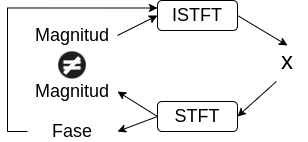

In [ ]:
#@title
original_phase_h = librosa.istft(estimated_h_spec,hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))
original_phase_p = librosa.istft(estimated_p_spec,hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))

print('Componentes armónicas (fase original)')
display(Audio(original_phase_h,rate=fs))
print('Componentes percusivas (fase original)')
display(Audio(original_phase_p,rate=fs))

random_phase_h = librosa.istft(np.abs(estimated_h_spec)*np.exp(1.0j*np.random.uniform(-np.pi,np.pi,size=estimated_h_spec.shape)),hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))
random_phase_p = librosa.istft(np.abs(estimated_p_spec)*np.exp(1.0j*np.random.uniform(-np.pi,np.pi,size=estimated_p_spec.shape)),hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))

print('Componentes armónicas (fase aleatoria)')
display(Audio(random_phase_h,rate=fs))
print('Componentes percusivas (fase aleatoria)')
display(Audio(random_phase_p,rate=fs))

gl_phase_h = librosa.griffinlim(estimated_h_spec,n_iter = 100,init=None,hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))
gl_phase_p = librosa.griffinlim(estimated_p_spec,n_iter = 100,init=None,hop_length=HOP_SIZE,win_length=WIN_SIZE,window=window[win_type](WIN_SIZE))

print('Componentes armónicas (fase estimada)')
display(Audio(gl_phase_h,rate=fs))
print('Componentes percusivas (fase estimada)')
display(Audio(gl_phase_p,rate=fs))